In [5]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-04-19 00:58:45--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.196.176, 216.58.197.80, 142.250.195.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.196.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  7.88MB/s    in 9.5s    

2021-04-19 00:58:56 (8.80 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [7]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [8]:
pre_trained_model = InceptionV3(input_shape = (150,150,3), 
                                include_top = False,
                               weights = None)

In [9]:
pre_trained_model.load_weights(local_weights_file)

In [10]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [11]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:',last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [13]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile( optimizer = RMSprop(lr=0.001),
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

In [16]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os 
import zipfile 

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip,'r')

zip_ref.extractall('/tmp')
zip_ref.close()


--2021-04-19 01:32:57--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.163.80, 142.250.182.144, 142.250.76.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.163.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  9.04MB/s    in 7.0s    

2021-04-19 01:33:04 (9.40 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [21]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")

train_cats_dir = os.path.join(train_dir, "cats")
train_dogs_dir = os.path.join(train_dir, "dogs")

validation_cats_dir = os.path.join(validation_dir, "cats")
validation_dogs_dir = os.path.join(validation_dir, "dogs")

train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

In [22]:
train_datagen = ImageDataGenerator(
                                    rescale =1.0/255.0 ,
                                    rotation_range =40 ,
                                    width_shift_range =0.2 ,
                                    height_shift_range = 0.2,
                                    shear_range =0.2,
                                    zoom_range = 0.2,
                                    fill_mode = 'nearest'
 )

validation_datagen = ImageDataGenerator(
                                    rescale =1.0/255.0
)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, target_size = (150,150), class_mode = 'binary')
validation_generator = validation_datagen.flow_from_directory(validation_dir, batch_size = 20, target_size = (150,150), class_mode='binary')

history = model.fit(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    validation_steps = 50,
                    verbose = 2
                   )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/2
100/100 - 112s - loss: 1.1348 - accuracy: 0.8320 - val_loss: 0.2002 - val_accuracy: 0.9330
Epoch 2/2
100/100 - 108s - loss: 0.3413 - accuracy: 0.8885 - val_loss: 0.1271 - val_accuracy: 0.9580


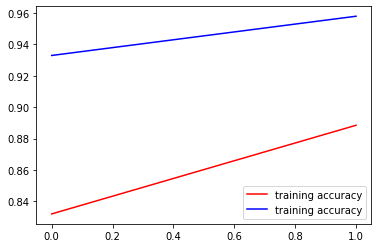

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='training accuracy')
plt.plot(epochs, val_acc, 'b',label='training accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()